In [1]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator
TRAINING_DIR = r'C:\Users\Hp\Documents\ML\Covid19-dataset\train'
TESTING_DIR = r'C:\Users\Hp\Documents\ML\Covid19-dataset\test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


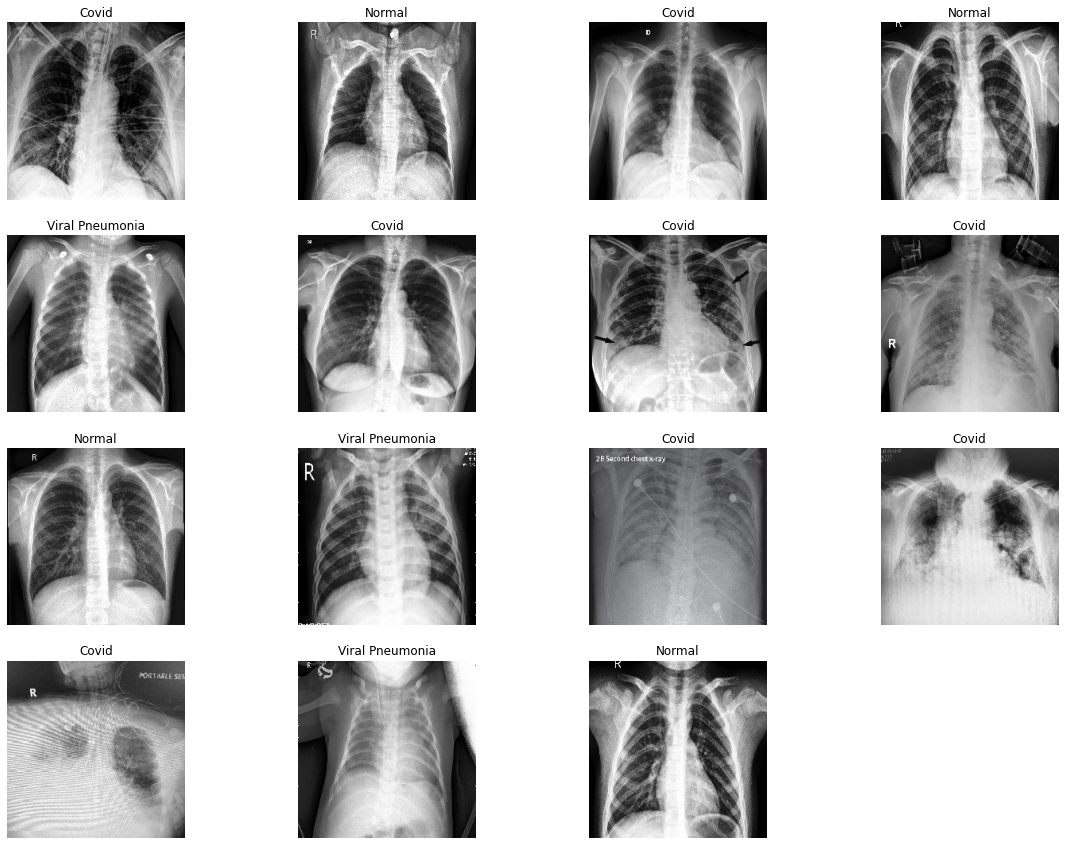

In [3]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,15)

In [4]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [5]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=20, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 1.1903 - acc: 0.3665
Epoch 1: acc improved from -inf to 0.36653, saving model to model\vgg16_best.h5
4/4 [==============================] - 29s 7s/step - loss: 1.1903 - acc: 0.3665 - val_loss: 1.0450 - val_acc: 0.3939
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 1.1278 - acc: 0.4382
Epoch 2: acc improved from 0.36653 to 0.43825, saving model to model\vgg16_best.h5
4/4 [==============================] - 27s 7s/step - loss: 1.1278 - acc: 0.4382 - val_loss: 0.9709 - val_acc: 0.3939
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 1.0136 - acc: 0.4622
Epoch 3: acc improved from 0.43825 to 0.46215, saving model to model\vgg16_best.h5
4/4 [==============================] - 27s 7s/step - loss: 1.0136 - acc: 0.4622 - val_loss: 0.9361 - val_acc: 0.6970
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.9543 - acc: 0.5259
Epoch 4: acc improved from 0.46215 to 0.52590, saving m

In [6]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


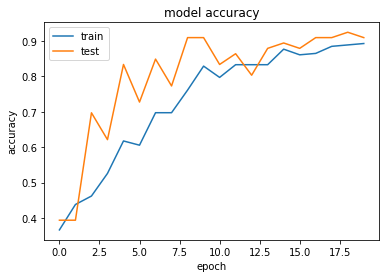

In [9]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

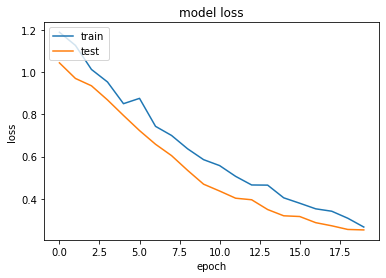

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
from tensorflow.keras.utils import load_img, img_to_array

path = r"C:\Users\Hp\Documents\ML\Covid19-dataset\train\Covid\03.jpeg"
img = load_img(path, target_size=(224,224))
x = img_to_array(img)
x /= 255
x.shape
x = x[np.newaxis,:,:]
x.shape
#images = np.vstack([x])
#classes = model_vgg16.predict(images)
#x = np.extend_dims(x, axis=0)

(1, 224, 224, 3)

In [29]:
model_vgg16.predict(x)

1/1 [==============================] - 0s 82ms/step


array([[0.01029564, 0.07381058, 0.9158938 ]], dtype=float32)

In [30]:
x[0]

array([[[0.03529412, 0.03529412, 0.03529412],
        [0.03137255, 0.03137255, 0.03137255],
        [0.03137255, 0.03137255, 0.03137255],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.02352941, 0.02352941, 0.02352941],
        [0.03137255, 0.03137255, 0.03137255]],

       [[0.03529412, 0.03529412, 0.03529412],
        [0.02745098, 0.02745098, 0.02745098],
        [0.03137255, 0.03137255, 0.03137255],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.03137255, 0.03137255, 0.03137255],
        [0.02352941, 0.02352941, 0.02352941]],

       [[0.03137255, 0.03137255, 0.03137255],
        [0.03137255, 0.03137255, 0.03137255],
        [0.03529412, 0.03529412, 0.03529412],
        ...,
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098]],

       ...,

       [[0.04313726, 0.04313726, 0.04313726],
        [0.04313726, 0.04313726, 0.04313726],
        [0.04313726, 0

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 99ms/step


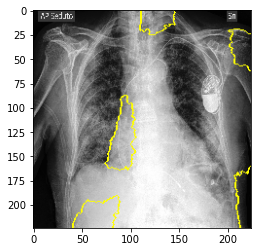

In [31]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(x[0].astype('double'), model_vgg16.predict)
plt.imshow(x[0])
temp, mask = explanation.get_image_and_mask(model_vgg16.predict(x).argmax(), positive_only=True)
plt.imshow(mark_boundaries(temp, mask))

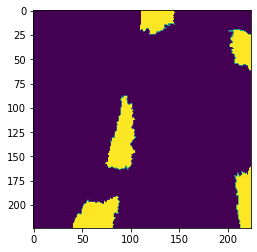

In [32]:
plt.imshow(mask)

In [11]:
path = r"C:\Users\Hp\Documents\ML\Covid19-dataset\train\Normal\03.jpeg"
img = load_img(path, target_size=(224,224))
x = img_to_array(img)
x /= 255
x = x[np.newaxis,:,:]

In [12]:
model_vgg16.predict(x)

1/1 [==============================] - 0s 86ms/step


array([[0.96632975, 0.01387322, 0.01979704]], dtype=float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 95ms/step


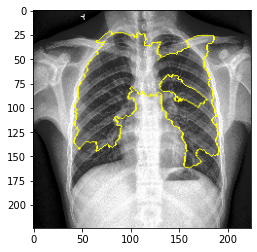

In [13]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(x[0].astype('double'), model_vgg16.predict)
plt.imshow(x[0])
temp, mask = explanation.get_image_and_mask(model_vgg16.predict(x).argmax(), positive_only=True)
plt.imshow(mark_boundaries(temp, mask))

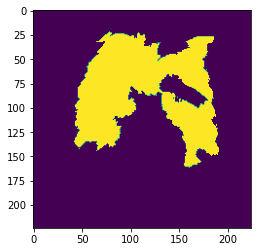

In [14]:
plt.imshow(mask)

In [15]:
path = r"C:\Users\Hp\Documents\ML\Covid19-dataset\train\Normal\04.jpeg"
img = load_img(path, target_size=(224,224))
x = img_to_array(img)
x /= 255
x = x[np.newaxis,:,:]

In [16]:
model_vgg16.predict(x)

1/1 [==============================] - 0s 86ms/step


array([[0.7850394 , 0.19782758, 0.01713294]], dtype=float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 87ms/step


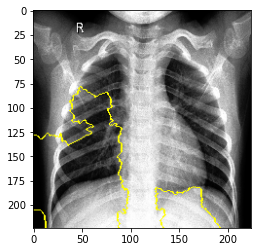

In [17]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(x[0].astype('double'), model_vgg16.predict)
plt.imshow(x[0])
temp, mask = explanation.get_image_and_mask(model_vgg16.predict(x).argmax(), positive_only=True)
plt.imshow(mark_boundaries(temp, mask))

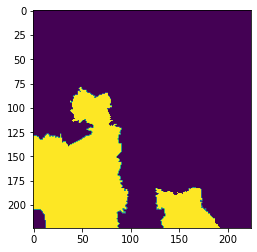

In [18]:
plt.imshow(mask)

In [19]:
path = r"C:\Users\Hp\Documents\ML\Covid19-dataset\train\Viral Pneumonia\04.jpeg"
x = img_to_array(img)
x /= 255
x = x[np.newaxis,:,:]
img = load_img(path, target_size=(224,224))

In [20]:
model_vgg16.predict(x)

1/1 [==============================] - 0s 88ms/step


array([[0.7850394 , 0.19782758, 0.01713294]], dtype=float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 93ms/step


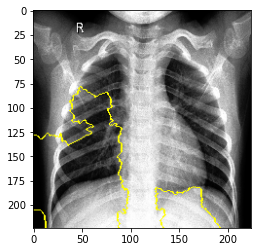

In [21]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(x[0].astype('double'), model_vgg16.predict)
plt.imshow(x[0])
temp, mask = explanation.get_image_and_mask(model_vgg16.predict(x).argmax(), positive_only=True)
plt.imshow(mark_boundaries(temp, mask))

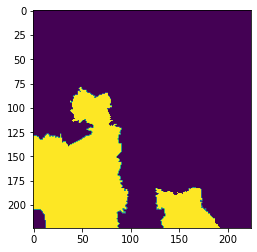

In [22]:
plt.imshow(mask)